# Imports

In [10]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [11]:
import os
import shutil
import random
from pathlib import Path

def split_data(input_dir, output_dir, train_ratio=0.6, test_ratio=0.2):
    # Set random seed for reproducibility
    random.seed(42)

    # Create output directories
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    valid_dir = os.path.join(output_dir, 'valid')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)

    # Get a list of all image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Shuffle the list of image files
    random.shuffle(image_files)

    # Calculate the number of images for each set
    total_images = len(image_files)
    train_count = int(train_ratio * total_images)
    test_count = int(test_ratio * total_images)

    # Copy images to the respective sets
    for i, image_file in enumerate(image_files):
        src_path = os.path.join(input_dir, image_file)

        if i < train_count:
            dst_path = os.path.join(train_dir, image_file)
        elif i < train_count + test_count:
            dst_path = os.path.join(test_dir, image_file)
        else:
            dst_path = os.path.join(valid_dir, image_file)

        shutil.copy(src_path, dst_path)


input_directory = "/kaggle/input/jodhpur"
output_directory = "/kaggle/working"

split_data(input_directory, output_directory)


# Custom Dataset

In [12]:
class Dataset(Dataset):

    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        

    def __len__(self):
        return len(self.img_list)
    
    
    def __getitem__(self, idx):
        path = self.img_list[idx]

        label = os.path.basename(path).split('.')[0].lower().strip()
        img = Image.open(path).convert('RGB')

        img_tensor = self.transform(img)
        return img_tensor, label

# CRNN Class

In [13]:
class CRNN(nn.Module):

    def __init__(self, vocab_size, dropout=0.5):
        super(CRNN, self).__init__()

        self.dropout = nn.Dropout(dropout)

        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(512, 512, (2,2), stride=1, padding=0),
            self.dropout
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(1024, 256),
            self.dropout
        )
        
        self.lstm_0 = nn.GRU(256, 256, bidirectional=True)  
        self.lstm_1 = nn.GRU(512, 256, bidirectional=True)

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x): 
        x = self.convlayer(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
     
        x = self.mapSeq(x)

        x, _ = self.lstm_0(x)
        x, _ = self.lstm_1(x)

        x = self.out(x)   
        return x.permute(1, 0, 2)

# OCR Class

In [14]:
class OCR:
    
    def __init__(self):
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.crnn = CRNN(VOCAB_SIZE).to(self.device)
        print('Model loaded to ', self.device)

        self.critertion = nn.CTCLoss(blank=0)

        self.char2idx, self.idx2char = self.char_idx()


    def char_idx(self):
        char2idx = {}
        idx2char = {}

        characters = CHARS.lower() + '-'
        for i, char in enumerate(characters):
            char2idx[char] = i + 1
            idx2char[i + 1] = char

        return char2idx, idx2char
        

    def encode(self, labels):
        length_per_label = [len(label) for label in labels]
        joined_label = ''.join(labels)

        joined_encoding = []
        for char in joined_label:
           joined_encoding.append(self.char2idx[char]) 

        return (torch.IntTensor(joined_encoding), torch.IntTensor(length_per_label) )


    def decode(self, logits):
        tokens = logits.softmax(2).argmax(2).squeeze(1)
        
        tokens = ''.join([self.idx2char[token] 
                        if token != 0  else '-' 
                        for token in tokens.numpy()])
        tokens = tokens.split('-')
        
        text = [char 
                for batch_token in tokens 
                for idx, char in enumerate(batch_token)
                if char != batch_token[idx-1] or len(batch_token) == 1]
        text = ''.join(text)
        
        return text
        

    def calculate_loss(self, logits, labels):
        encoded_labels, labels_len = self.encode(labels)

        logits_lens = torch.full(
            size=(logits.size(1),), 
            fill_value=logits.size(0), 
            dtype=torch.int32
        ).to(self.device)

        return self.critertion(
            logits.log_softmax(2), encoded_labels, 
            logits_lens, labels_len
        )


    def train_step(self, optimizer, images, labels):
        logits = self.predict(images)

        optimizer.zero_grad()
        loss = self.calculate_loss(logits, labels)
        loss.backward()
        optimizer.step()

        return logits, loss

    
    def val_step(self, images, labels):
        logits = self.predict(images)
        loss = self.calculate_loss(logits, labels)

        return logits, loss


    def predict(self, img):
        return self.crnn(img.to(self.device))


    def train(self, num_epochs, optimizer, train_loader, val_loader, print_every=2):
        train_losses, valid_losses = [], []

        for epoch in range(num_epochs):

            tot_train_loss = 0
            self.crnn.train()
            for i, (images, labels) in enumerate(train_loader):
                logits, train_loss = self.train_step(optimizer, images, labels)
                
                tot_train_loss += train_loss.item()

            with torch.no_grad():

                tot_val_loss = 0
                self.crnn.eval()
                for i, (images, labels) in enumerate(val_loader):
                    logits, val_loss = self.val_step(images, labels)

                    tot_val_loss += val_loss.item()
                
                train_loss = tot_train_loss / len(train_loader.dataset)
                val_loss = tot_val_loss / len(val_loader.dataset)

                train_losses.append(train_loss)
                valid_losses.append(val_loss)

            if epoch % print_every == 0:
                print('Epoch [{:5d}/{:5d}] | train loss {:6.4f} | val loss {:6.4f}'.format(
                    epoch+1,
                    num_epochs,
                    train_loss,
                    val_loss
                )) 

        return train_losses, valid_losses

# Train CRNN

In [15]:
TRAIN_DIR = '/kaggle/working/train'
VAL_DIR = '/kaggle/working/valid'
TEST_DIR = '/kaggle/working/test'
BATCH_SIZE = 8
N_WORKERS = 0

CHARS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
VOCAB_SIZE = len(CHARS) + 1

lr = 0.02
weight_decay = 1e-5
momentum = 0.7

EPOCHS = 10

In [16]:
# Dataset
train_dataset = Dataset(TRAIN_DIR)
val_dataset = Dataset(VAL_DIR)
test_dataset = Dataset(TEST_DIR)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS, shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, 
    num_workers=N_WORKERS, shuffle=False
)
# Model
ocr = OCR()

# Optimizer | Paper used Adadelta
optimizer = optim.SGD(
    ocr.crnn.parameters(), lr=lr, nesterov=True,
    weight_decay=weight_decay, momentum=momentum
)


# train
train_losses, val_losses = ocr.train(EPOCHS, optimizer, val_loader, train_loader, print_every=1)

Model loaded to  cuda
Epoch [    1/   10] | train loss 0.4699 | val loss 0.4612
Epoch [    2/   10] | train loss 0.4250 | val loss 0.3319
Epoch [    3/   10] | train loss 0.2210 | val loss 0.1580
Epoch [    4/   10] | train loss 0.1251 | val loss 0.1010
Epoch [    5/   10] | train loss 0.0904 | val loss 0.0950
Epoch [    6/   10] | train loss 0.0695 | val loss 0.0837
Epoch [    7/   10] | train loss 0.0556 | val loss 0.0770
Epoch [    8/   10] | train loss 0.0448 | val loss 0.0814
Epoch [    9/   10] | train loss 0.0371 | val loss 0.0772
Epoch [   10/   10] | train loss 0.0304 | val loss 0.0823


# Results

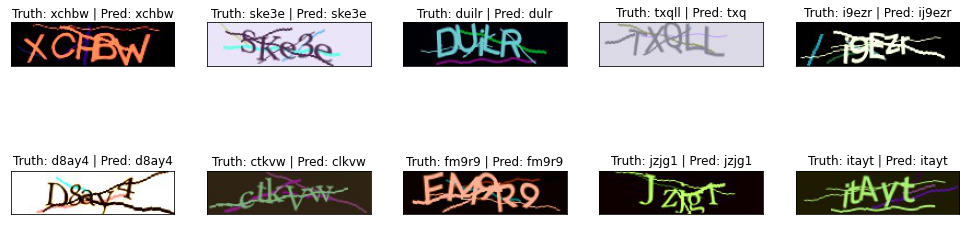

In [17]:
# view samples
sample_result = []

for i in range(10):
    idx = np.random.randint(len(val_dataset))
    img, label = val_dataset[idx]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())

    sample_result.append( (img, label, pred_text) )

fig = plt.figure(figsize=(17, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(title)

plt.show() 

In [19]:
correct_label = []
preds = []
for i in range(len(val_dataset)):
    img, label = val_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on validation dataset : {accuracy * 100:.2f}%")

Accuracy on validation dataset : 65.75%


In [23]:
correct_label = []
preds = []
for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on test dataset : {accuracy * 100:.2f}%")

Accuracy on test dataset : 44.97%


In [24]:
correct_label = []
preds = []
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on train dataset : {accuracy * 100:.2f}%")

Accuracy on train dataset : 45.30%


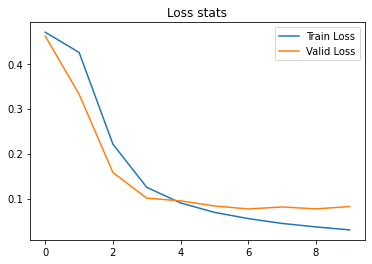

In [21]:
# plot loss stats
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.title('Loss stats')
plt.legend()
plt.show()

In [25]:
train_losses, val_losses = ocr.train(EPOCHS, optimizer, val_loader, train_loader, print_every=1)

Epoch [    1/   10] | train loss 0.0254 | val loss 0.0817
Epoch [    2/   10] | train loss 0.0209 | val loss 0.0819
Epoch [    3/   10] | train loss 0.0188 | val loss 0.0839
Epoch [    4/   10] | train loss 0.0156 | val loss 0.0834
Epoch [    5/   10] | train loss 0.0138 | val loss 0.0985
Epoch [    6/   10] | train loss 0.0122 | val loss 0.0908
Epoch [    7/   10] | train loss 0.0107 | val loss 0.0944
Epoch [    8/   10] | train loss 0.0095 | val loss 0.0914
Epoch [    9/   10] | train loss 0.0078 | val loss 0.0927
Epoch [   10/   10] | train loss 0.0073 | val loss 0.0969


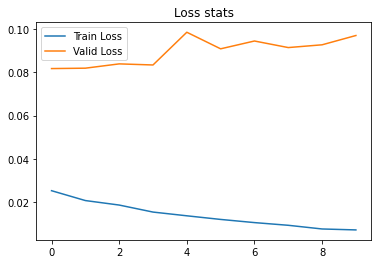

In [26]:
# plot loss stats
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.title('Loss stats')
plt.legend()
plt.show()

In [27]:
correct_label = []
preds = []
for i in range(len(val_dataset)):
    img, label = val_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on validation dataset : {accuracy * 100:.2f}%")

Accuracy on validation dataset : 77.73%


In [28]:
correct_label = []
preds = []
for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on test dataset : {accuracy * 100:.2f}%")

Accuracy on test dataset : 47.37%


In [29]:
correct_label = []
preds = []
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    logits = ocr.predict(img.unsqueeze(0))
    pred_text = ocr.decode(logits.cpu())
    correct_label.append(label)
    preds.append(pred_text)
correct_predictions = sum(1 for true, pred in zip(correct_label, preds) if true == pred)
total_samples = len(correct_label)
accuracy = correct_predictions / total_samples

print(f"Accuracy on train dataset : {accuracy * 100:.2f}%")

Accuracy on train dataset : 47.78%
